# Resources:
- https://arxiv.org/pdf/2105.08655.pdf
- https://sahilkhose.medium.com/paper-presentation-e9bd0f3fb0bf
- https://towardsdatascience.com/binary-image-classification-in-pytorch-5adf64f8c781
- https://www.mdpi.com/2073-4441/15/5/875

# Imports

In [1]:
! pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 41.7 MB/s eta 0:00:00


In [2]:
import zipfile
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from sklearn.model_selection import train_test_split
import torch
import torchvision
from torch.utils.data import TensorDataset, DataLoader,Dataset
from torchvision import datasets, transforms,models
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
from torch.optim import lr_scheduler
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import calinski_harabasz_score
from torchvision.datasets import ImageFolder
import albumentations
from sklearn.metrics import f1_score
from keras.preprocessing.image import ImageDataGenerator
import timm

In [3]:
# Mount to Google Drive
from google.colab import drive
drive.mount('/content/drive')

# change directory to the folder where the data is stored
%cd /content/drive/My Drive/SAT/project

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1CM7mfjvEpCrXOEDAzssGF2m9qbIhtM1y/SAT/project


# Helpers

In [4]:
def extract_file(zip_path,specified_directory):
  with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(specified_directory)

In [5]:
def read_images(flooded_path, non_flooded_path, width, height):
    flooded = np.empty((0, width, height, 3))
    non_flooded = np.empty((0, width, height, 3))

    for filename in os.listdir(flooded_path):
        img = cv2.imread(os.path.join(flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0 
        img = np.expand_dims(img, axis=0)
        flooded = np.concatenate((flooded, img), axis=0)

    for filename in os.listdir(non_flooded_path):
        img = cv2.imread(os.path.join(non_flooded_path, filename), cv2.IMREAD_COLOR)
        img = cv2.resize(img, (width, height)) 
        img = img.astype('float32') / 255.0  
        img = np.expand_dims(img, axis=0) 
        non_flooded = np.concatenate((non_flooded, img), axis=0)
    return flooded,non_flooded

In [6]:
def show_img(img,title=""):
   plt.imshow(img)
   plt.title(title)
   plt.show()

In [7]:
def show_images(images,images_labels):
  nrows = 4
  ncols = 4
  fig, ax = plt.subplots(nrows,ncols,figsize = (10,10))
  ax = ax.flatten()
  for i in range(nrows*ncols):
      pic = images[i%8]
      ax[i].imshow(pic)
      ax[i].set_title(images_labels[i%8])
      ax[i].set_axis_off()
  plt.show()

In [8]:
def calc_metrics(y,y_pred,model_name):
    cm = confusion_matrix(y, y_pred)
    cr = classification_report(y, y_pred)
    fn = cm[1][0]
    pos = cm[1][0] + cm[1][1]
    omission_error = fn / pos
    fp = cm[0][1]
    neg = cm[0][0] + cm[0][1]
    commission_error = fp / neg
    print(f"Model: {model_name}")
    print(cm)
    print(cr)
    print("Omission error rate:", omission_error)
    print("Commission error rate:", commission_error)

# Constants

In [9]:
CFG = {
    'img_size': 256, # width and height of the image
    'epochs': 10, # number of epochs
    'train_bs': 16, # batch size for training
    'val_bs': 32, # batch size for validation
    'test_bs': 32, # batch size for testing
    'lr': 1e-5, # learning rate
    'freeze': False, # if you want to freeze pretrain model weights
    'out_features': 1, # number of output features (1 for binary classification)
    'dataset_path': 'dataset/dataset', # path to the root dataset folder
    'flooded_path': 'dataset/dataset/flooded', # path to the flooded images
    'non_flooded_path': 'dataset/dataset/non-flooded', # path to the non flooded images
    'val_ratio': 0.4, # ratio for validation set
    'early_stopping_tolerance': 5,  # early stopping patience (using grid search)
    'early_stopping_threshold': 0.03 # early stopping threshold (using grid search)
    }

# Load the data

In [10]:
# extract_file("./dataset.zip","./dataset")

In [11]:
# flooded, non_flooded = read_images(CFG['flooded_path'], CFG['non_flooded_path'], CFG['img_size'], CFG['img_size'])

In [12]:
# print("flooded images shapes",flooded.shape)
# print("non_flooded images shapes",non_flooded.shape)

In [13]:
# X = np.concatenate((flooded, non_flooded), axis=0)
# Y = np.concatenate((np.ones(flooded.shape[0]), np.zeros(non_flooded.shape[0])), axis=0)

# Avoid Loading and resizing the data each time.
- save X and Y.
- Instead of running the previous cells, just load X, Y.

In [14]:
# # Save the array to a file
# np.save('X.npy', X)
# # Save the array to a file
# np.save('Y.npy', Y)

In [15]:
# Load the array from the file
X = np.load('X.npy')
# Load the array from the file
Y = np.load('Y.npy')

# Split the dataset

In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=CFG['val_ratio'], stratify=Y, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, stratify=Y_val, random_state=42)

In [17]:
  print(X_train.shape, Y_train.shape)
  print(X_val.shape, Y_val.shape)
  print(X_test.shape, Y_test.shape)

(553, 256, 256, 3) (553,)
(184, 256, 256, 3) (184,)
(185, 256, 256, 3) (185,)


In [18]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='reflect'
)

# Generate augmented images for the training set
train_gen = datagen.flow(X_train, Y_train, batch_size=32)
augmented_X_train, augmented_Y_train = next(train_gen)
for i in range(20):
    batch = next(train_gen)
    augmented_X_train = np.concatenate([augmented_X_train, batch[0]])
    augmented_Y_train = np.concatenate([augmented_Y_train, batch[1]])

# add augmented data to the training set
X_train = np.concatenate([X_train, augmented_X_train])
Y_train = np.concatenate([Y_train, augmented_Y_train])

# Generate augmented images for the testing set
val_gen = datagen.flow(X_val, Y_val, batch_size=32)
augmented_X_val, augmented_Y_val = next(val_gen)
for i in range(10):
    batch = next(val_gen)
    augmented_X_val = np.concatenate([augmented_X_val, batch[0]])
    augmented_Y_val = np.concatenate([augmented_Y_val, batch[1]])

# add augmented data to the validation set
X_val = np.concatenate([X_val, augmented_X_val])
Y_val = np.concatenate([Y_val, augmented_Y_val])

In [19]:
  print(X_train.shape, Y_train.shape)
  print(X_val.shape, Y_val.shape)
  print(X_test.shape, Y_test.shape)

(1202, 256, 256, 3) (1202,)
(528, 256, 256, 3) (528,)
(185, 256, 256, 3) (185,)


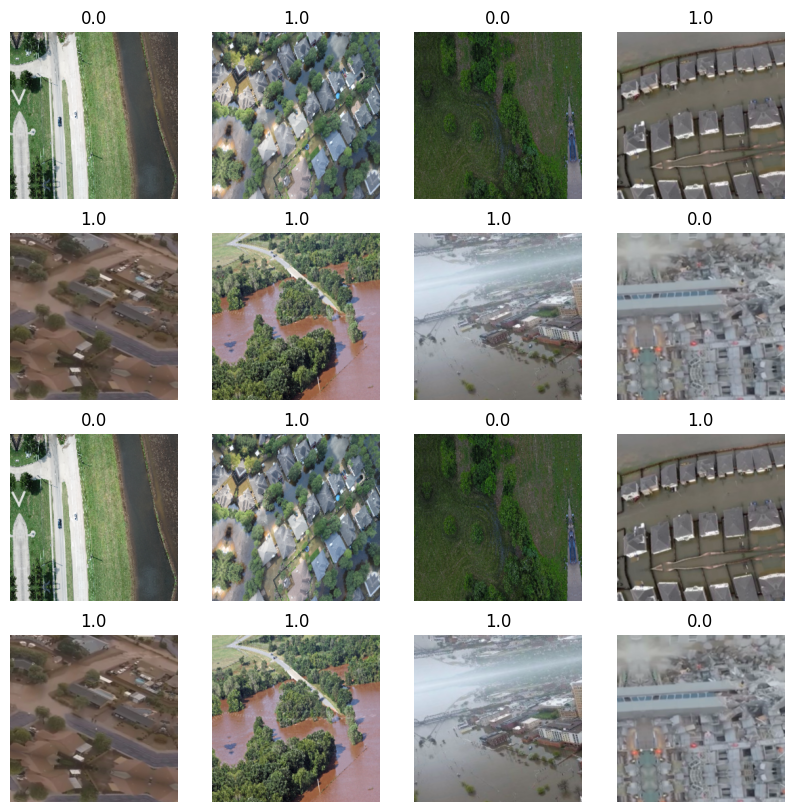

In [20]:
show_images(augmented_X_train, augmented_Y_train)

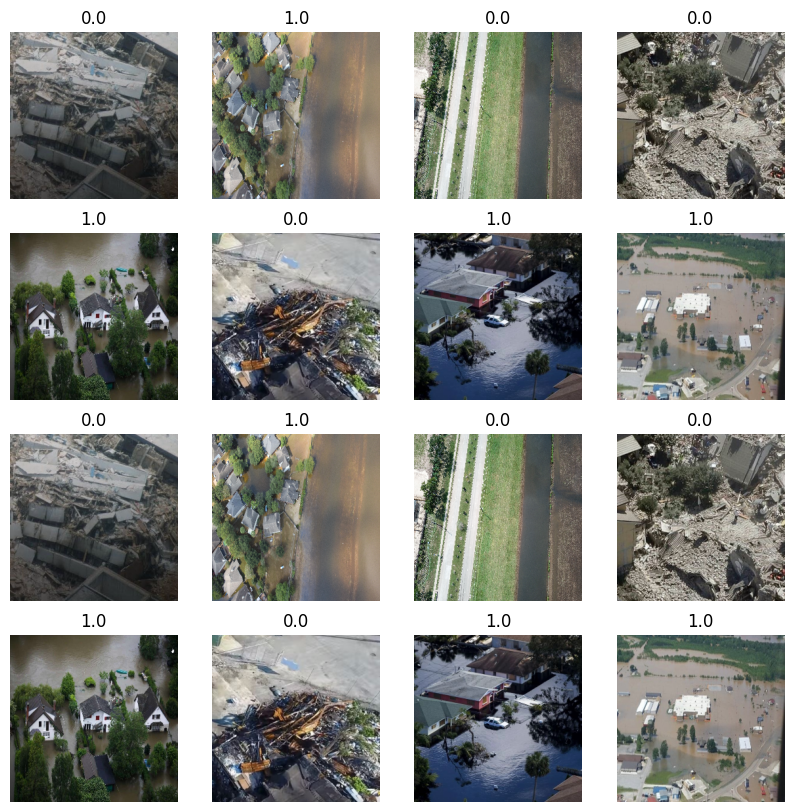

In [21]:
show_images(X_train, Y_train)

# Augmentation

In [22]:
train_aug = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomVerticalFlip(p=0.5),
            transforms.RandomRotation(degrees=(-45, 45)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])

val_aug = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            )
        ])

# Dataset and DataLoader

In [23]:
X_train_tensor = torch.from_numpy(X_train).float()
Y_train_tensor = torch.from_numpy(Y_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
Y_val_tensor = torch.from_numpy(Y_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
Y_test_tensor = torch.from_numpy(Y_test).float()

In [24]:
train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_dataset.transforms = train_aug
val_dataset = TensorDataset(X_val_tensor, Y_val_tensor)
val_dataset.transforms = val_aug
test_dataset = TensorDataset(X_test_tensor, Y_test_tensor)

In [25]:
  train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=CFG['train_bs'], shuffle=True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=CFG['val_bs'], shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=CFG['test_bs'], shuffle=True)

# Model

In [40]:
class Efficientnet(nn.Module):
    def __init__(self, pretrained=True, freeze=CFG['freeze'], out_features=CFG['out_features']):
        super(Efficientnet, self).__init__()

        self.model = timm.create_model('efficientnet_b0', pretrained=pretrained)

        if freeze:
            for param in self.model.parameters():
                param.requires_grad = False

        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, out_features)

    def forward(self, x):
        return self.model(x)

# Train the model

In [41]:
def train(model, train_loader, optimizer, criterion, device):
    y_true = []
    y_pred = []
    running_loss = 0.0
    for batch_idx, (input, target) in enumerate(tqdm(train_loader)):
            # Get data to cuda if possible
            input = input.permute(0, 3, 1, 2)
            input = input.to(device=device)
            target = target.unsqueeze(1).float()
            target = target.to(device=device)

            # forward
            scores = model(input)
            loss = criterion(scores, target)

            # backward
            optimizer.zero_grad()
            loss.backward()

            running_loss += loss.item()
            # gradient descent or adam step
            optimizer.step()

            predicted = torch.round(torch.sigmoid(scores))
            y_true.extend(target.flatten().tolist())
            y_pred.extend(predicted.flatten().tolist())

    return running_loss/len(train_loader), f1_score(y_true, y_pred, average='macro')

In [42]:
def evaluate(model, val_loader, criterion, device):
    model.eval()
    y_true = []
    y_pred = []
    running_loss = 0.0
    with torch.no_grad():
      for batch_idx, (input, target) in enumerate(tqdm(val_loader)):
            input = input.permute(0, 3, 1, 2)
            input = input.to(device)
            target = target.unsqueeze(1).float()
            target = target.to(device)

            scores = model(input)
            loss = criterion(scores, target)

            running_loss += loss.item()

            predicted = torch.round(torch.sigmoid(scores))
            y_true.extend(target.flatten().tolist())
            y_pred.extend(predicted.flatten().tolist())

    return running_loss/len(val_loader), f1_score(y_true, y_pred, average='macro')

In [43]:
def run(model, train_loader, val_loader, epochs, device):
    criterion = nn.BCEWithLogitsLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'])

    early_stopping_counter = 0
    best_loss = float("inf")
    best_f1 = 0
    for epoch in range(epochs):
        train_loss, train_f1 = train(model, train_loader, optimizer, criterion, device)
        val_loss, val_f1 = evaluate(model, val_loader, criterion, device)
        
        best_loss = min(best_loss, val_loss)

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"best_efficientnet.pt")
        else:
            early_stopping_counter += 1

        print(f"    Training loss: {train_loss} Training macro f1: {100*train_f1:.2f}% Validation loss: {val_loss} Validation macro f1: {100*val_f1:.2f}%")

        if early_stopping_counter == CFG['early_stopping_tolerance'] or best_loss <= CFG['early_stopping_threshold']:
            print("\nTerminating: early stopping")
            return

In [44]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [45]:
  model = Efficientnet()
  model = model.to(device)
  run(model, train_loader, val_loader, epochs=20, device=device)

100%|██████████| 17/17 [00:00<00:00, 19.23it/s]


    Training loss: 0.6448323593327874 Training macro f1: 70.67% Validation loss: 0.5692269872216618 Validation macro f1: 87.06%


100%|██████████| 17/17 [00:00<00:00, 19.09it/s]


    Training loss: 0.3673359316430594 Training macro f1: 92.08% Validation loss: 0.15822354222045226 Validation macro f1: 97.54%


100%|██████████| 17/17 [00:00<00:00, 19.28it/s]


    Training loss: 0.10492231705422073 Training macro f1: 97.84% Validation loss: 0.07221871658283122 Validation macro f1: 98.11%


100%|██████████| 17/17 [00:00<00:00, 18.42it/s]


    Training loss: 0.047102344577739895 Training macro f1: 98.75% Validation loss: 0.05112666286089841 Validation macro f1: 98.48%


100%|██████████| 17/17 [00:00<00:00, 18.83it/s]


    Training loss: 0.02425973304075581 Training macro f1: 99.08% Validation loss: 0.04273585438290063 Validation macro f1: 99.05%


100%|██████████| 17/17 [00:00<00:00, 18.00it/s]


    Training loss: 0.012545647324785884 Training macro f1: 99.67% Validation loss: 0.04511975653825656 Validation macro f1: 98.67%


100%|██████████| 17/17 [00:00<00:00, 19.01it/s]


    Training loss: 0.006503174311977713 Training macro f1: 99.92% Validation loss: 0.054824274498969316 Validation macro f1: 98.30%


100%|██████████| 17/17 [00:00<00:00, 18.92it/s]


    Training loss: 0.005159222152877574 Training macro f1: 100.00% Validation loss: 0.054497267448288554 Validation macro f1: 98.30%


100%|██████████| 17/17 [00:00<00:00, 18.98it/s]


    Training loss: 0.002783123600980425 Training macro f1: 100.00% Validation loss: 0.055460273315582204 Validation macro f1: 98.30%


100%|██████████| 17/17 [00:00<00:00, 18.30it/s]

    Training loss: 0.0013775086290958203 Training macro f1: 100.00% Validation loss: 0.047406149591552094 Validation macro f1: 98.67%

Terminating: early stopping


# Load best model

In [49]:
model = Efficientnet().to(device)
model.load_state_dict(torch.load('final_best_efficientnet.pt'))

<All keys matched successfully>

In [50]:
criterion = nn.BCEWithLogitsLoss()
val_loss, val_f1 = evaluate(model, val_loader, criterion, device)
print(f"Validation loss: {val_loss} Validation macro f1: {100*val_f1:.2f}%")

100%|██████████| 17/17 [00:01<00:00, 13.68it/s]

Validation loss: 0.042013893780462885 Validation macro f1: 99.05%


In [51]:
criterion = nn.BCEWithLogitsLoss()
test_loss, test_f1 = evaluate(model, test_loader, criterion, device)
print(f"test loss: {test_loss} test macro f1: {100*test_f1:.2f}%")

100%|██████████| 6/6 [00:00<00:00, 12.27it/s]

test loss: 0.035318405755485095 test macro f1: 98.92%
